## Gate cutting to reduce circuit width

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList

Specify a circuit and some observables

In [2]:
circuit = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

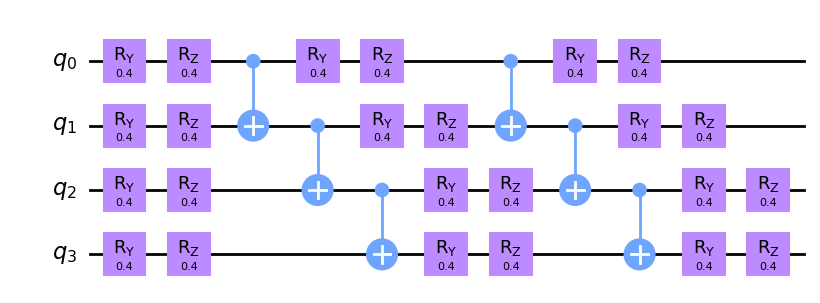

In [3]:
circuit.draw('mpl')

Cut the circuit and observables by using `partition_problem` and specifying qubit partitions

In [4]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=circuit,
    partition_labels="AABB",
    num_samples=np.inf,
    observables=observables,
)
partitioned_problem._fields

('subcircuits', 'subexperiments', 'subobservables', 'weights', 'bases')

Run the subexperiments for each partition using the Qiskit Aer primitives and recombine the results.

In [5]:
from qiskit_aer.primitives import Sampler

# Set up Qiskit Aer Sampler primitives.
sampler_a = Sampler(run_options={"shots": 2**12})
sampler_b = Sampler(run_options={"shots": 2**12})

# Retrieve the quasi-probability distributions for each subexperiment
quasi_dists_a = (
    sampler_a.run(partitioned_problem.subexperiments["A"]).result().quasi_dists
)
quasi_dists_b = (
    sampler_b.run(partitioned_problem.subexperiments["B"]).result().quasi_dists
)
quasi_dists = {"A": quasi_dists_a, "B": quasi_dists_b}

To run using Qiskit Runtime primitives, rather than Qiskit Aer, replace the code above with this commented block.

In [6]:
#from qiskit_ibm_runtime import Session, Options, Sampler

#with Session(backend="ibmq_qasm_simulator") as session:
#    options = Options()
#    options.execution.shots = 2**14
#    sampler_a = Sampler(options=options)
#    sampler_b = Sampler(options=options)

#    job_a = sampler_a.run(partitioned_problem.subexperiments["A"])
#    job_b = sampler_b.run(partitioned_problem.subexperiments["B"])

#    quasi_dists_a = job_a.result().quasi_dists
#    quasi_dists_b = job_b.result().quasi_dists
    
#    session.close()

#quasi_dists = {"A": quasi_dists_a, "B": quasi_dists_b}

Reconstruct the full expectation value, given the results of cutting

In [7]:
from circuit_knitting.cutting import reconstruct_expectation_values

simulated_expvals = reconstruct_expectation_values(
    partitioned_problem.subobservables,
    partitioned_problem.weights,
    quasi_dists,
)
simulated_expvals

[0.3985081911087035,
 0.5109944939613341,
 0.5899204015731809,
 0.10524165630340576,
 0.3238300085067748,
 -0.11753767728805539]

In [8]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table